In [3]:
# Imports

import os
import joblib
import pandas as pd

from src.modsec import init_modsec
from src.utils import load_data_label_vector
from src.model import train_model, test_evasion
from config import BaseConfig

In [4]:
# Setup Variables

Config = BaseConfig()
data_path = max( # use the most recent prepared data
    [os.path.join("data/prepared/", d) for d in os.listdir("data/prepared/")],
    key=os.path.getmtime,
)

print(f"Using data from {data_path}")

Using data from data/prepared/2024-03-19-20-35-02


In [5]:
# Load Data

train = load_data_label_vector(f"{data_path}/train.csv")
test = load_data_label_vector(f"{data_path}/test.csv")
train_adv = load_data_label_vector(f"{data_path}/train_adv.csv")
test_adv = load_data_label_vector(f"{data_path}/test_adv.csv")

Model trained successfully!
Evaluating model...
Default threshold: 0.5
FRP is currently at 0.037
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       100
           1       0.96      0.87      0.91       120

    accuracy                           0.91       220
   macro avg       0.91      0.91      0.91       220
weighted avg       0.91      0.91      0.91       220



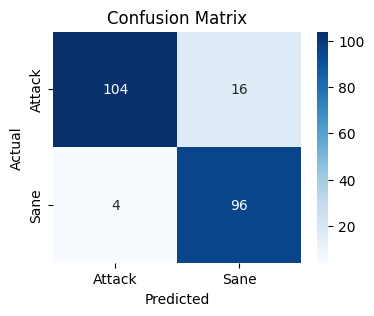

Adjusting threshold to match desired FPR of 0.01


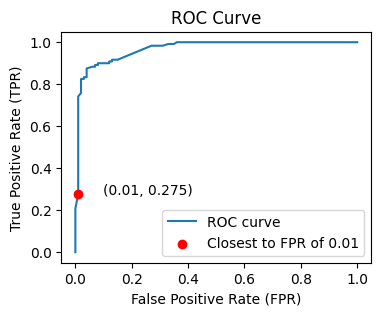

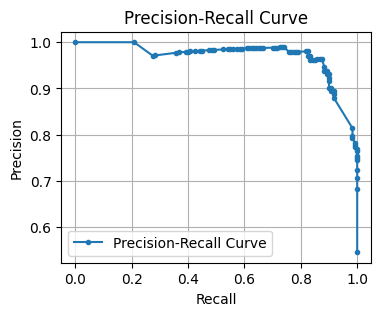

Adjusted threshold: 0.9938 with FPR of 0.01 (closest to desired FPR 0.01)
              precision    recall  f1-score   support

           0       0.53      0.99      0.69       100
           1       0.97      0.28      0.43       120

    accuracy                           0.60       220
   macro avg       0.75      0.63      0.56       220
weighted avg       0.77      0.60      0.55       220



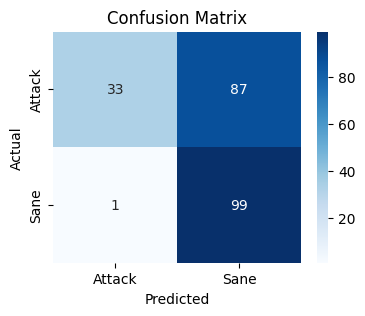

In [6]:
# Load/Train Models

model_trained = joblib.load(f"{data_path}/model.joblib")
threshold = float(open(f"{data_path}/threshold.txt", "r").read())

model_adv_trained, threshold_adv = train_model(
    train=pd.concat([train, train_adv]).sample(frac=1).reset_index(drop=True),
    test=pd.concat([test, test_adv]).sample(frac=1).reset_index(drop=True),
    model=Config.MODEL_ADV,
    desired_fpr=Config.DESIRED_FPR,
)

In [7]:
# Test Evasion (base model without adversarial training)

test_evasion(
    payload='SELECT SLEEP(5)#";',
    threshold=threshold,
    model=model_trained,
    engine_eval_settings={
        "max_rounds": 200,
        "round_size": 10,
        "timeout": 60,
        "threshold": 0.0,
    },
    modsec=init_modsec(),
    rule_ids=Config.RULE_IDS,
    paranoia_level=Config.PARANOIA_LEVEL,
)

Payload: SELECT SLEEP(5)#";
Vec: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
Confidence: 0.90143


[!] Max number of iterations reached
Reached confidence 0.5210329663267543
with payload
SELECT SLEEP((SELECT (SELECT 5)))   AND   True AND
True AND 0x1 AND 1#";yg
Min payload: b'SELECT SLEEP((SELECT (SELECT 5)))   AND   True AND\nTrue AND 0x1 AND 1#";yg'
Min confidence: 0.52103
Reduced confidence from 0.90143 to 0.52103 (reduction of 0.3804)

Evasion successful


In [8]:
# Test Evasion (adversarially trained model)

test_evasion(
    payload='SELECT SLEEP(5)#";',
    threshold=threshold,
    model=model_adv_trained,
    engine_eval_settings={
        "max_rounds": 200,
        "round_size": 10,
        "timeout": 60,
        "threshold": 0.0,
    },
    modsec=init_modsec(),
    rule_ids=Config.RULE_IDS,
    paranoia_level=Config.PARANOIA_LEVEL,
)

Payload: SELECT SLEEP(5)#";
Vec: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
Confidence: 0.83411
[!] Max number of iterations reached
Reached confidence 0.5941378210836832
with payload
SELECT
SLEEP(0x5) AND (SELECT 6505) NOT  LIKE  (SELECT 6506) && NkbV LIKE NkbV#";\
Min payload: b'SELECT\nSLEEP(0x5) AND (SELECT 6505) NOT  LIKE  (SELECT 6506) && NkbV LIKE NkbV#";\\'
Min confidence: 0.59414
Reduced confidence from 0.83411 to 0.59414 (reduction of 0.23997)

Evasion successful
